In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # For progress bars

import config
import utils
from hmm_model import HangmanHMM
from hangman_env import HangmanEnv
from rl_agent import HangmanAgent

In [5]:
import pickle

# Load the HMM *dictionary*
print("Loading HMM model dictionary...")
with open(config.HMM_MODEL_PATH, 'rb') as f:
    all_hmms = pickle.load(f)
print(f"Loaded {len(all_hmms)} HMMs (one for each word length).")

# (Rest of the cell is the same)
print("Loading corpus for environment...")
corpus = utils.load_corpus(config.CORPUS_PATH)
env = HangmanEnv(corpus)
agent = HangmanAgent(config.STATE_SIZE, config.ACTION_SIZE)
rewards_history = []
epsilon_history = []
epsilon_history = []

Loading HMM model dictionary...
Loaded 24 HMMs (one for each word length).
Loading corpus for environment...
Loaded 49979 valid words from corpus.txt.


In [3]:
print(f"Starting training for {config.NUM_EPISODES_TRAIN} episodes...")

# This diagram shows how the components interact in the loop


for episode in tqdm(range(config.NUM_EPISODES_TRAIN)):
    # 1. Reset environment for a new game
    env_state = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        # 2. Get HMM probabilities for the current state
        hmm_probs = hmm.get_letter_probabilities(
            env_state['masked_word'], 
            env_state['guessed_letters']
        )
        
        # 3. Convert state + HMM probs into a single vector for the NN
        state_vec = agent.state_to_vector(env_state, hmm_probs)
        
        # 4. Agent selects an action (epsilon-greedy)
        action_idx = agent.select_action(state_vec, env_state['guessed_letters'])
        action_letter = config.ALPHABET[action_idx]
        
        # 5. Environment executes the action
        next_env_state, reward, done, info = env.step(action_letter)
        episode_reward += reward
        
        # 6. Get the *next* state vector
        next_hmm_probs = hmm.get_letter_probabilities(
            next_env_state['masked_word'],
            next_env_state['guessed_letters']
        )
        next_state_vec = agent.state_to_vector(next_env_state, next_hmm_probs)
        
        # 7. Store this transition in the agent's replay buffer
        agent.memory.add(state_vec, action_idx, reward, next_state_vec, done)
        
        # 8. Train the agent's network
        agent.optimize_model()
        
        # Move to the next state
        env_state = next_env_state
    
    # --- End of Episode ---
    
    # 9. Log rewards and decay epsilon
    rewards_history.append(episode_reward)
    epsilon_history.append(agent.epsilon)
    agent.decay_epsilon()
    
    # 10. Sync the target network periodically
    if episode % 100 == 0:
        agent.update_target_network()
        
    # Optional: Print progress
    if episode % 500 == 0:
        print(f"\nEpisode {episode} | Avg. Reward (last 100): {np.mean(rewards_history[-100:]):.2f} | Epsilon: {agent.epsilon:.3f}")

print("Training complete.")

# 11. Save the trained agent's weights
torch.save(agent.q_network.state_dict(), config.AGENT_MODEL_PATH)
print(f"Agent model weights saved to {config.AGENT_MODEL_PATH}")

Starting training for 10000 episodes...


  0%|          | 0/10000 [00:00<?, ?it/s]


Episode 0 | Avg. Reward (last 100): -6.00 | Epsilon: 0.995

Episode 500 | Avg. Reward (last 100): -4.02 | Epsilon: 0.081

Episode 1000 | Avg. Reward (last 100): -4.17 | Epsilon: 0.010

Episode 1500 | Avg. Reward (last 100): -5.12 | Epsilon: 0.010

Episode 2000 | Avg. Reward (last 100): -3.95 | Epsilon: 0.010

Episode 2500 | Avg. Reward (last 100): -4.36 | Epsilon: 0.010

Episode 3000 | Avg. Reward (last 100): -4.48 | Epsilon: 0.010

Episode 3500 | Avg. Reward (last 100): -3.44 | Epsilon: 0.010

Episode 4000 | Avg. Reward (last 100): -2.79 | Epsilon: 0.010

Episode 4500 | Avg. Reward (last 100): -3.23 | Epsilon: 0.010

Episode 5000 | Avg. Reward (last 100): -4.38 | Epsilon: 0.010

Episode 5500 | Avg. Reward (last 100): -4.51 | Epsilon: 0.010

Episode 6000 | Avg. Reward (last 100): -3.36 | Epsilon: 0.010

Episode 6500 | Avg. Reward (last 100): -4.29 | Epsilon: 0.010

Episode 7000 | Avg. Reward (last 100): -4.07 | Epsilon: 0.010

Episode 7500 | Avg. Reward (last 100): -2.69 | Epsilon: 0.

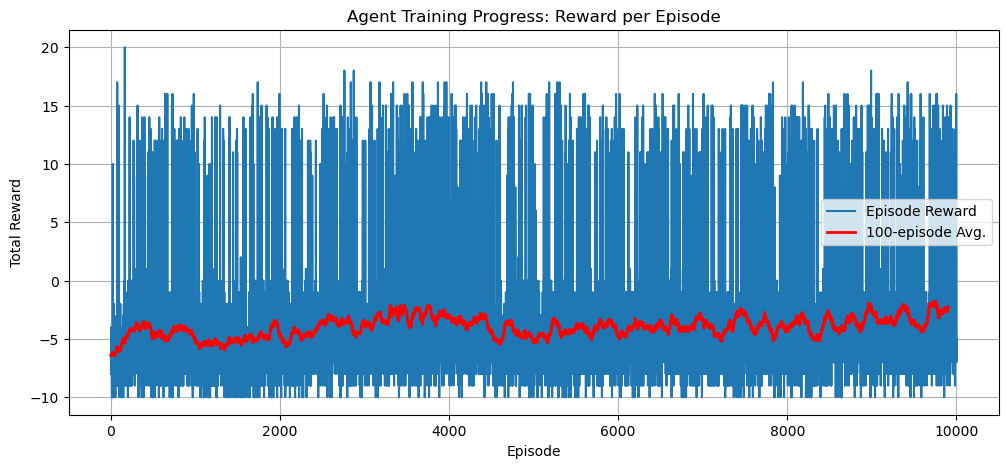

In [4]:
# Create a simple plot of rewards over time
plt.figure(figsize=(12, 5))
plt.plot(rewards_history, label='Episode Reward')
# Create a rolling average to see the trend
rolling_avg = np.convolve(rewards_history, np.ones(100)/100, mode='valid')
plt.plot(rolling_avg, label='100-episode Avg.', color='red', linewidth=2)
plt.title('Agent Training Progress: Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()